# Predicting stock prices with Autogluon project


## Data exploration

In [27]:
import pandas as pd
from io import StringIO

### Parameter definition

Let's use Apple (AAPL) as an example, with a lookback period of 30 months and a forecast one of 10 months

In [55]:
# Parameters
ticker = 'AAPL'
forecast_months = 12
lookback_months = 36

### Data Gathering

We'll get the data from `query1.finance.yahoo.com` providing above params, via a regular http request  

Sample data url: https://query1.finance.yahoo.com/v7/finance/download/AAPL?period1=1550793600&period2=1645488000&interval=1d&events=history&includeAdjustedClose=true

In [68]:
import time
import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import os
import boto3


def get_data_df(ticker, period1, period2, suffix=''):
    int_period1 = int(time.mktime(period1.timetuple()))
    int_period2 = int(time.mktime(period2.timetuple()))
    interval = '1d' # 1d, 1m    
    url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={int_period1}&period2={int_period2}&interval={interval}&events=history&includeAdjustedClose=true'
    print(url)
    df = pd.read_csv(url)
    df = df.rename(columns={'Adj Close': 'Adj_Close'})
    return df



In [ ]:
period2 = datetime.date.today()
period1 = period2 - relativedelta(months=lookback_months)

df = get_data_df(ticker, period1, period2)
df

### Exploration

We're going to use the train split for data exploration

In [57]:
df = df_train
df.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2018-10-22,54.947498,55.840000,54.735001,55.162498,53.296410,115168400
1,2018-10-23,53.957500,55.812500,53.674999,55.682499,53.798820,155071200
2,2018-10-24,55.650002,56.057499,53.634998,53.772499,51.953426,163702000
3,2018-10-25,54.427502,55.345001,54.187500,54.950001,53.091095,119423200
4,2018-10-26,53.974998,55.047501,53.167500,54.075001,52.245701,189033600


Let's plot the evolution of the Adjusted Close price through time

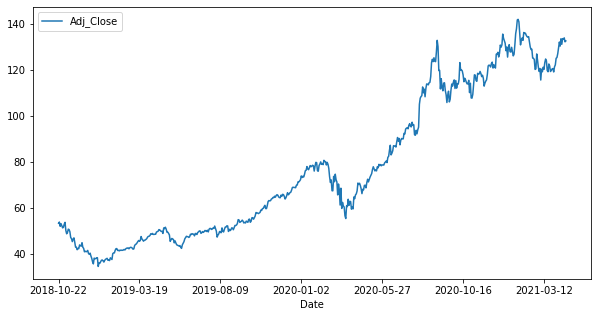

In [58]:
df.plot(x='Date', y='Adj_Close', figsize=(10,5))

For this stock, we can observe an ascending behavior in general. Prices between 40 and 140 aprox

Let's check the data distribution

In [34]:
df.describe()

,Open,High,Low,Close,Adj_Close,Volume
count,628.000000,628.000000,628.000000,628.000000,628.000000,6.280000e+02
mean,78.181644,79.155991,77.198416,78.226035,77.156960,1.349292e+08
std,31.799664,32.194446,31.233977,31.725079,31.829700,6.111411e+07
min,35.994999,36.430000,35.500000,35.547501,34.464798,4.544800e+07
25%,50.683750,51.097500,50.239375,50.686250,49.475480,9.249275e+07
50%,68.684998,69.791252,67.537498,68.772499,67.759960,1.185214e+08
75%,113.964998,115.460001,112.227501,113.579998,112.508507,1.615198e+08
max,143.600006,145.089996,141.369995,143.160004,142.101822,4.265100e+08


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f38638a7bd0>,
      dtype=object)

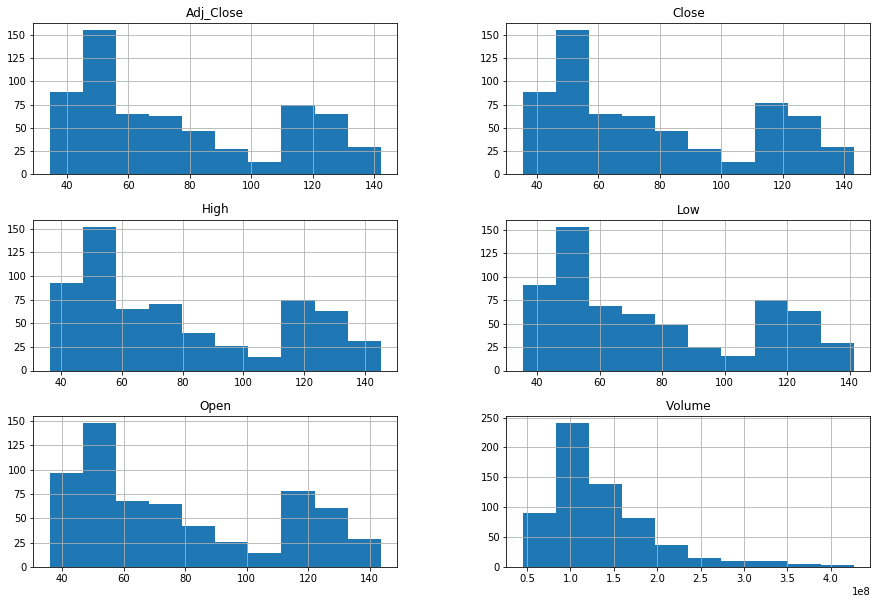

In [39]:
df.hist(figsize=(15,10))

We can observe that all numeric fields have a similar distribution, bimodal in this example.
This could be very dependent on the stock

Except for the volume, which follows a log normal distribution

Let's check the Gold (GLD) stock distribution for the same period

In [60]:
df_gld, _ = gather_data('GLD', forecast_months, lookback_months)
df_gld.describe()

,Open,High,Low,Close,Adj_Close,Volume
count,754.000000,754.000000,754.000000,754.000000,754.000000,7.540000e+02
mean,141.617745,142.184244,140.960756,141.584164,141.584164,9.537452e+06
std,22.895355,23.076991,22.585924,22.851123,22.851123,5.367505e+06
min,111.459999,111.879997,111.059998,111.099998,111.099998,2.250900e+06
25%,122.072502,122.365000,121.745002,121.987503,121.987503,6.083875e+06
50%,137.979996,138.440002,137.620002,137.974998,137.974998,8.129050e+06
75%,161.880005,162.575001,160.854996,162.142505,162.142505,1.170478e+07
max,193.740005,194.449997,192.520004,193.889999,193.889999,4.535500e+07


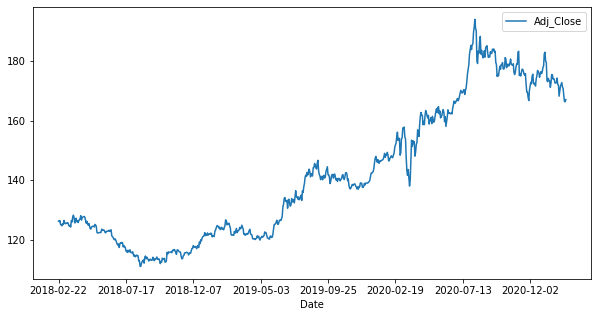

In [61]:
df_gld.plot(x='Date', y='Adj_Close', figsize=(10,5))

Gold also has an ascending behavior in general

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3861d9d710>,
      dtype=object)

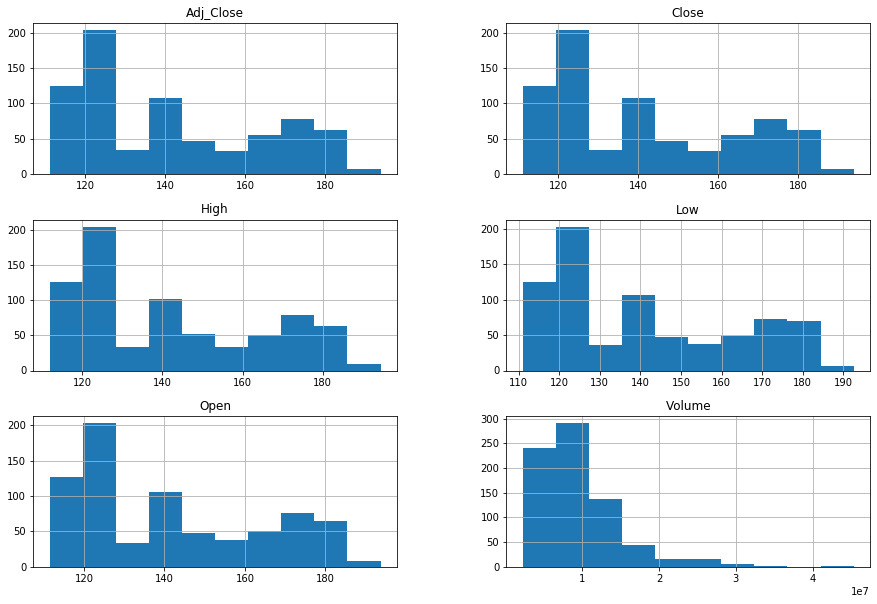

In [62]:
df_gld.hist(figsize=(15,10))

We can observe that the prices distribution is very different. However, the volume is also log normal
We don't notice the presence of outliers or atypical data.

### Data cleaning

The data comes clean from source (Yahoo Finance) so it does not need cleaning. Also, given it provides an Adjusted Close field, we don't need to do further calculations